# Tweeter Sentiments Analyses


## 1- Install Dependancies


In [4]:
# install the required packages
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2- Load Dataset


In [5]:
import os

DATA_DIR = "./data/"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

DATASETS_DIR = os.listdir(DATA_DIR)
print(DATASETS_DIR)

RESULTS_DIR = "./results/"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)


['sentiment140.csv']


In [6]:
import pandas as pd

dataset = DATASETS_DIR[0]
# Load the dataset
df = pd.read_csv(
    os.path.join(DATA_DIR, dataset), encoding="latin-1", sep=",", header=None
)

#  we noticed that the columns names are messing we will fix them using the data discreption
df.columns = ["target", "ids", "date", "flag", "user", "text"]

df.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 3- Explotary Data Analyses


In [33]:
# moving forward will will analyse messsing data
print("messing data: ", df.isnull().sum(), sep="\n")
df.dropna(inplace=True)
print("messing data: ", df.isnull().sum(), sep="\n")
# checking unique values in the dataset
print("unique values: ", df.nunique(), sep="\n")


messing data: 
target         1
ids            1
date           1
user           1
text           1
text_length    1
year           1
month          1
dtype: int64
messing data: 
target         0
ids            0
date           0
user           0
text           0
text_length    0
year           0
month          0
dtype: int64
unique values: 
target               2
ids            1598315
date            774363
user            659775
text           1581466
text_length        257
year                 1
month                3
dtype: int64


In [8]:
# we noticed that the flag column has only one value  we will drop it
df.drop(columns=["flag"], inplace=True)
print(df.head())


   target         ids                          date             user  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009         mattycus   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009          ElleCTF   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009           Karoli   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [26]:
print("data types: ", df.dtypes, sep="\n")

data types: 
target          int64
ids             int64
date           object
user           object
text           object
text_length     int64
dtype: object


### Data Visalusation


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette

sns.set_palette("husl", 8)


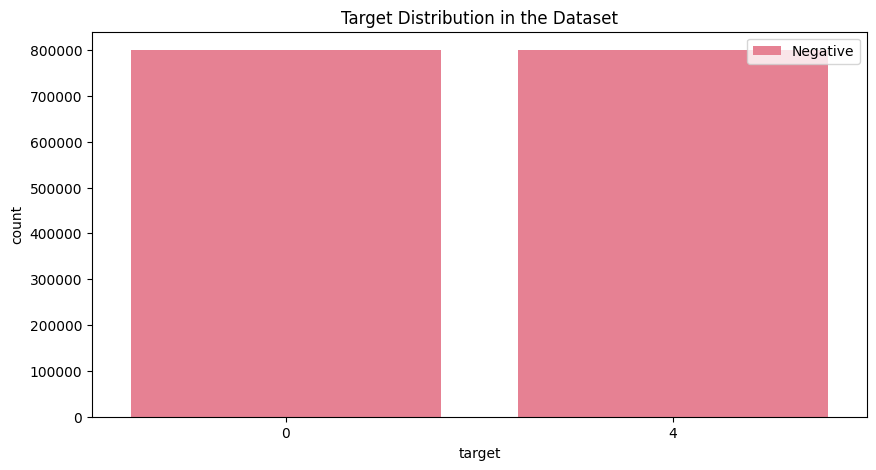

In [23]:
#  visulization the distrubtion of dataset target
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="target")
plt.title("Target Distribution in the Dataset")
plt.legend(["Negative", "Positive"])
plt.savefig(RESULTS_DIR + "target_distribution.png")
plt.show()


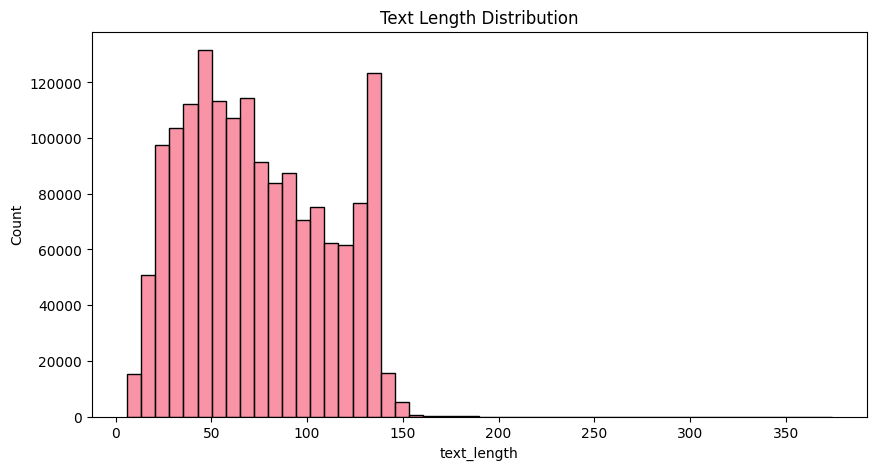

In [24]:
# visuaize the distribution of the text length
df.loc[:, "text_length"] = df.loc[:, "text"].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=50)
plt.title("Text Length Distribution")
plt.savefig(RESULTS_DIR + "text_length_distribution.png")
plt.show()


In [29]:
# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"], format="%a %b %d %H:%M:%S +0000 %Y", utc=True)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month


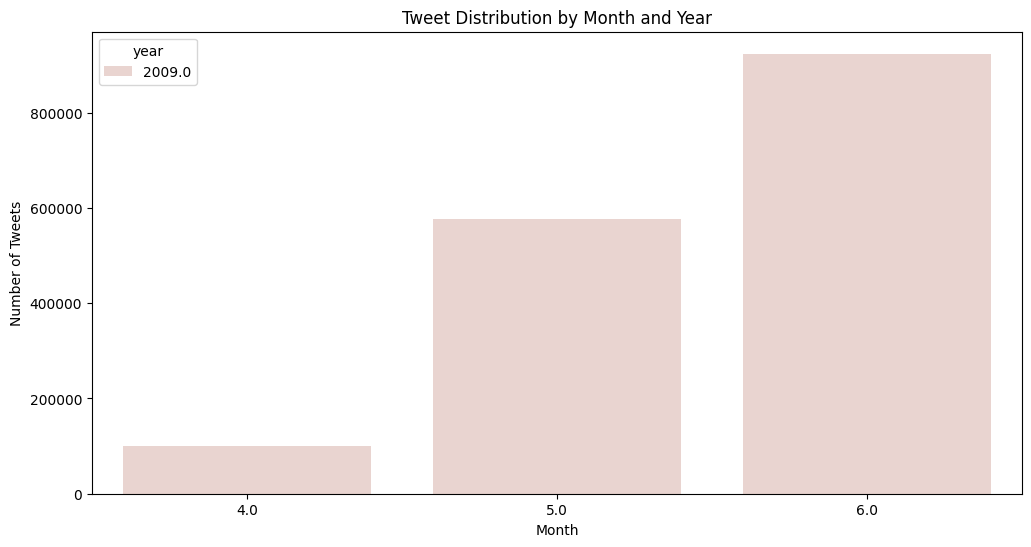

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df.groupby(["year", "month"]).size().reset_index(name="count"),
    x="month",
    y="count",
    hue="year",
)
plt.title("Tweet Distribution by Month and Year")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.savefig(RESULTS_DIR + "tweet_month_year_distribution.png")
plt.show()


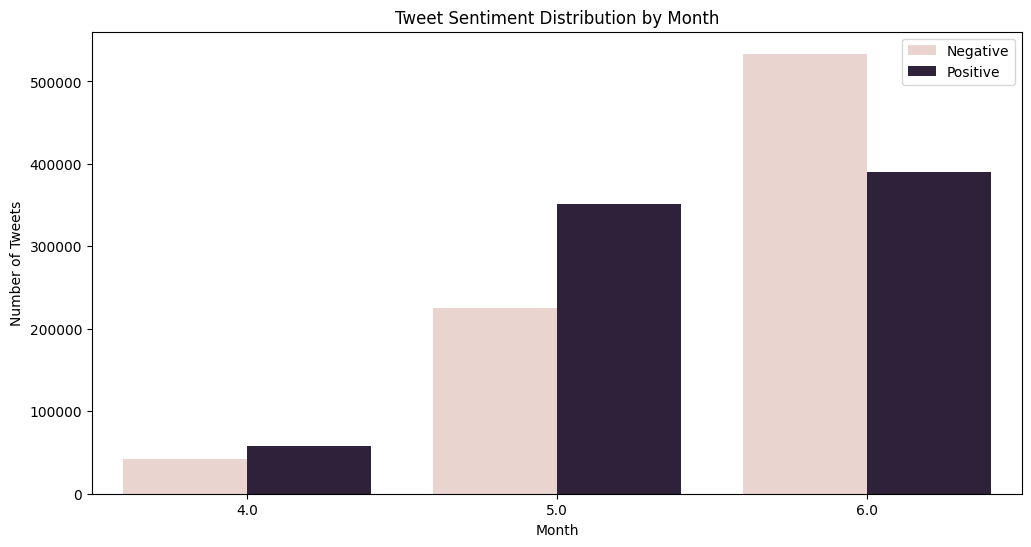

In [35]:
# visualize thetype of the tweet for by month and year
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="month", hue="target")
plt.title("Tweet Sentiment Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.legend(["Negative", "Positive"])
plt.savefig(RESULTS_DIR + "tweet_sentiment_month_distribution.png")
plt.show()


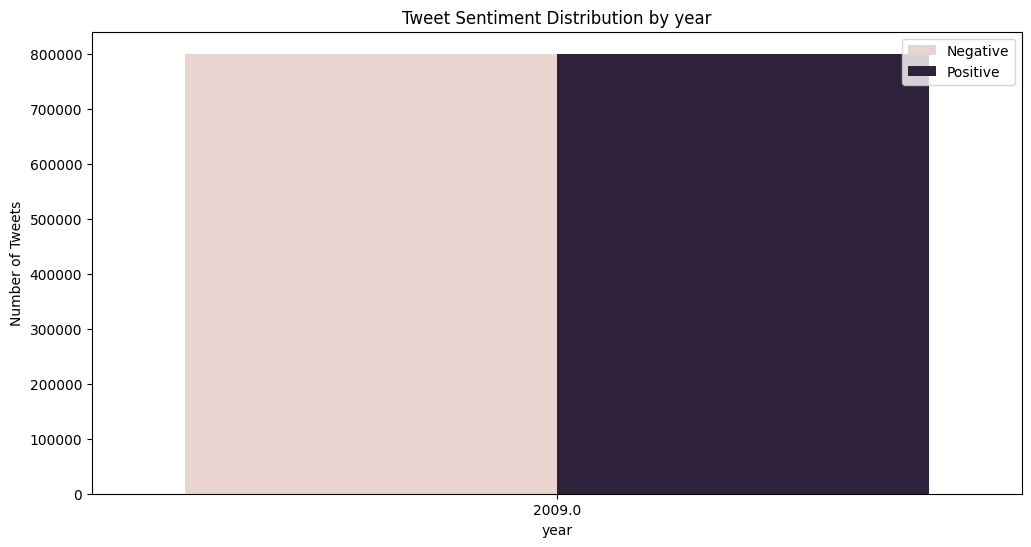

In [36]:
# visualize thetype of the tweet for by  year
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="year", hue="target")
plt.title("Tweet Sentiment Distribution by year")
plt.xlabel("year")
plt.ylabel("Number of Tweets")
plt.legend(["Negative", "Positive"])
plt.savefig(RESULTS_DIR + "tweet_sentiment_year_distribution.png")
plt.show()


## 3- Preprocessing
